# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

# Importing Libraries and Creating Spark Session

In [104]:
# import libraries
import pyspark
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import (sum, col, when, lit, round, from_unixtime, split, 
                                   concat, regexp_replace, percentile,
                                   count, countDistinct, max, min, avg, 
                                   date_format, date_part, date_trunc, to_timestamp
                                  )
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import time
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [105]:
# Apply the changes to the current session
import os
os.environ['JAVA_HOME'] = '/workspace/jdk'
os.environ['PATH'] = f"{os.environ['JAVA_HOME']}/bin:{os.environ['PATH']}"

In [106]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify Project").getOrCreate()

In [107]:
def display_pandas_dataframe(df_filtered, number_limit = 5):
    df_limited = df_filtered.limit(number_limit)
    return df_limited.toPandas()

# Load Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [108]:
##reading json
df = spark.read.json("mini_sparkify_event_data.json")

In [109]:
##displaying a sample of data
df.limit(3).show()

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   

In [110]:
##pltting in a pandas df to a better visualization 
display_pandas_dataframe(df)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [111]:
# print the schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



The dataframe has 18 columns, 12 columns being a string value, and the other 6 columns beign numerical values. 

In [112]:
# print the schema
df.count()

286500

There are 286,5K lines in the Dataframe. 

# Clean Dataset

1. Looking for null values

In [113]:
#list of columns
list_of_columns = df.columns

#creating dict to store null values
dict_null_values = {col_name: df.filter(col(f'{col_name}').isNull()).count() for col_name in list_of_columns}
print(dict_null_values)

{'artist': 58392, 'auth': 0, 'firstName': 8346, 'gender': 8346, 'itemInSession': 0, 'lastName': 8346, 'length': 58392, 'level': 0, 'location': 8346, 'method': 0, 'page': 0, 'registration': 8346, 'sessionId': 0, 'song': 58392, 'status': 0, 'ts': 0, 'userAgent': 8346, 'userId': 0}


There are a few null values in the dataset, mainly in artist, firstName, lastName, gender, leght, location, registration, song and userAgent column. Let's check some rows containing these null records.

In [114]:
display_pandas_dataframe(df.filter(col('artist').isNull()))

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,None,Logged In,Micah,M,84,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1538331630000,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,None,Logged In,Micah,M,86,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1538331630000,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
3,None,Logged In,Alexi,F,4,Warren,NaN,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1532482662000,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
4,None,Logged In,Alexi,F,7,Warren,NaN,paid,"Spokane-Spokane Valley, WA",PUT,Thumbs Up,1532482662000,53,None,307,1538355255000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54


In [115]:
(df.withColumn('is_none_artist', 
               when(col('artist').isNull(), lit('Null value'))
               .otherwise(lit('Not null value'))
              )
   .withColumn('is_none_song', 
               when(col('song').isNull(), lit('Null value'))
               .otherwise(lit('Not null value'))
              )
   .withColumn('is_none_length', 
               when(col('length').isNull(), lit('Null value'))
               .otherwise(lit('Not null value'))
              )
).groupBy('is_none_artist', 'is_none_song', 'is_none_length').count().show()

+--------------+--------------+--------------+------+
|is_none_artist|  is_none_song|is_none_length| count|
+--------------+--------------+--------------+------+
|    Null value|    Null value|    Null value| 58392|
|Not null value|Not null value|Not null value|228108|
+--------------+--------------+--------------+------+



The null values in artist, song and length records seems to be related with events not including an interaction with any music. So, we will fill these null values with this information.

In [116]:
df = (df
      .withColumn('artist', when(col('artist').isNull(), lit('no_music_info')).otherwise(col('artist')))
      .withColumn('song', when(col('song').isNull(), lit('no_music_info')).otherwise(col('song')))
     )

In [117]:
display_pandas_dataframe(df.filter(col('location').isNull()))

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,no_music_info,Logged Out,None,None,100,None,NaN,free,None,GET,Home,NaN,8,no_music_info,200,1538355745000,None,
1,no_music_info,Logged Out,None,None,101,None,NaN,free,None,GET,Help,NaN,8,no_music_info,200,1538355807000,None,
2,no_music_info,Logged Out,None,None,102,None,NaN,free,None,GET,Home,NaN,8,no_music_info,200,1538355841000,None,
3,no_music_info,Logged Out,None,None,103,None,NaN,free,None,PUT,Login,NaN,8,no_music_info,307,1538355842000,None,
4,no_music_info,Logged Out,None,None,2,None,NaN,free,None,GET,Home,NaN,240,no_music_info,200,1538356678000,None,


It seems that a relation between null values in First Name, Last Name, Location, Gender, registration, userAgent with Logged Out sessions.

In [118]:
(df.withColumn('is_none_gender', 
               when(col('gender').isNull(), lit('Null value'))
               .otherwise(lit('Not null value'))
              )
   .withColumn('is_none_location', 
               when(col('location').isNull(), lit('Null value'))
               .otherwise(lit('Not null value'))
              )
   .withColumn('is_none_registration', 
               when(col('location').isNull(), lit('Null value'))
               .otherwise(lit('Not null value'))
              )
   .withColumn('is_none_userAgent', 
               when(col('userAgent').isNull(), lit('Null value'))
               .otherwise(lit('Not null value'))
              )
).groupBy('auth',
          'is_none_gender', 'is_none_location', 
          'is_none_registration', 'is_none_userAgent').count().show()

+----------+--------------+----------------+--------------------+-----------------+------+
|      auth|is_none_gender|is_none_location|is_none_registration|is_none_userAgent| count|
+----------+--------------+----------------+--------------------+-----------------+------+
| Logged In|Not null value|  Not null value|      Not null value|   Not null value|278102|
| Cancelled|Not null value|  Not null value|      Not null value|   Not null value|    52|
|     Guest|    Null value|      Null value|          Null value|       Null value|    97|
|Logged Out|    Null value|      Null value|          Null value|       Null value|  8249|
+----------+--------------+----------------+--------------------+-----------------+------+



How we can not know of kow is the user acessing the app in Logged Out Sessions, or Guest Sessions, information about these types of interactions can not be helpful to the Churn Analysis. Also, the represent a small portion of dataset. Due to this, there records will be dropped.

In [119]:
df = df.filter(col('auth').isin(['Logged In', 'Cancelled']))

In [120]:
#list of columns
list_of_columns = df.columns

#creating dict to store null values
dict_null_values = {col_name: df.filter(col(f'{col_name}').isNull()).count() for col_name in list_of_columns}
print(dict_null_values)

{'artist': 0, 'auth': 0, 'firstName': 0, 'gender': 0, 'itemInSession': 0, 'lastName': 0, 'length': 50046, 'level': 0, 'location': 0, 'method': 0, 'page': 0, 'registration': 0, 'sessionId': 0, 'song': 0, 'status': 0, 'ts': 0, 'userAgent': 0, 'userId': 0}


Right now, there is no  null value in te dataset, besides the length column, that has null values in cases of song/artist with no music information. 

2. Checking Data Types

In [121]:
display_pandas_dataframe(df).dtypes

artist            object
auth              object
firstName         object
gender            object
itemInSession      int64
lastName          object
length           float64
level             object
location          object
method            object
page              object
registration       int64
sessionId          int64
song              object
status             int64
ts                 int64
userAgent         object
userId            object
dtype: object

There is only one problem with dtypes: datetime information should be in datetime format. This must be true even in registration columns, as in ts column. Let's do this convertion.

In [122]:
df = (df.withColumn('registration_datetime', 
                    from_unixtime(col('registration')/1000, 
                                  "yyyy-MM-dd HH:mm:ss")
                   )
         .withColumn('ts_datetime', 
                    from_unixtime(col('ts')/1000, 
                                  "yyyy-MM-dd HH:mm:ss")
                   )
     )

In [123]:
df.withColumn('registration_datetime', from_unixtime(col('registration')/1000, "yyyy-MM-dd HH:mm:ss")).select('registration_datetime', 'registration', 'ts', 'ts_datetime').limit(2).show()

+---------------------+-------------+-------------+-------------------+
|registration_datetime| registration|           ts|        ts_datetime|
+---------------------+-------------+-------------+-------------------+
|  2018-09-28 22:22:42|1538173362000|1538352117000|2018-10-01 00:01:57|
|  2018-09-30 18:20:30|1538331630000|1538352180000|2018-10-01 00:03:00|
+---------------------+-------------+-------------+-------------------+



In [124]:
df = (df
      .withColumn('ts', col('ts_datetime'))
      .withColumn('registration', col('registration_datetime'))
      .drop('registration_datetime', 'ts_datetime')
     )

In [125]:
display_pandas_dataframe(df).dtypes

artist            object
auth              object
firstName         object
gender            object
itemInSession      int64
lastName          object
length           float64
level             object
location          object
method            object
page              object
registration      object
sessionId          int64
song              object
status             int64
ts                object
userAgent         object
userId            object
dtype: object

In [126]:
display_pandas_dataframe(df.groupBy('userAgent').count().orderBy(col('count').desc()), 
                         number_limit = 100)

25/08/16 04:32:46 WARN DAGScheduler: Broadcasting large task binary with size 1008.9 KiB


,userAgent,count
0,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",22751
1,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",19611
2,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18448
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",17348
4,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,16700
5,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",15395
6,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",14598
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,10300
8,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",8912
9,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,8624


3. Changing specific columns not so useful: first_name and last_name, location, userAgent

In [127]:
df = (df.withColumn('city', split(col('location'), ",").getItem(0))
        .withColumn('state', split(col('location'), ",").getItem(1))
      .drop('location')
     )

In [128]:
display_pandas_dataframe(df.groupBy('city').count())

,city,count
0,Fairbanks,2067
1,Detroit-Warren-Dearborn,2332
2,Anchorage,1496
3,Port St. Lucie,117
4,Miami-Fort Lauderdale-West Palm Beach,3764


In [129]:
df = (df.withColumn('fullName', concat(concat(col('firstName'), lit(" ")), col('lastName')))
      .drop('firstName', 'lastName')
     )

In [130]:
df = (df.withColumn('new_userAgent', regexp_replace(col('userAgent'),"\"|\'", ""))
        .withColumn('new_userAgent', regexp_replace(col('new_userAgent'),"Mozilla/5.0", ""))
        .withColumn('operacional_system', when(col('new_userAgent').like('%Windows%'), lit('Windows'))
                                         .when(col('new_userAgent').like('%Ubuntu%'), lit('Ubuntu/Linux'))
                                         .when(col('new_userAgent').like('%Linux%'), lit('Ubuntu/Linux'))
                                         .when(col('new_userAgent').like('%Mobi%'), lit('Mobi'))
                                         .when(col('new_userAgent').like('%Mac%'), lit('Mac'))
                   )
         .withColumn('userAgent', col('operacional_system'))
         .drop('new_userAgent', 'operacional_system')
     )

In [131]:
display_pandas_dataframe(df)

,artist,auth,gender,itemInSession,length,level,method,page,registration,sessionId,song,status,ts,userAgent,userId,city,state,fullName
0,Martha Tilston,Logged In,M,50,277.89016,paid,PUT,NextSong,2018-09-28 22:22:42,29,Rockpools,200,2018-10-01 00:01:57,Windows,30,Bakersfield,CA,Colin Freeman
1,Five Iron Frenzy,Logged In,M,79,236.09424,free,PUT,NextSong,2018-09-30 18:20:30,8,Canada,200,2018-10-01 00:03:00,Windows,9,Boston-Cambridge-Newton,MA-NH,Micah Long
2,Adam Lambert,Logged In,M,51,282.82730,paid,PUT,NextSong,2018-09-28 22:22:42,29,Time For Miracles,200,2018-10-01 00:06:34,Windows,30,Bakersfield,CA,Colin Freeman
3,Enigma,Logged In,M,80,262.71302,free,PUT,NextSong,2018-09-30 18:20:30,8,Knocking On Forbidden Doors,200,2018-10-01 00:06:56,Windows,9,Boston-Cambridge-Newton,MA-NH,Micah Long
4,Daft Punk,Logged In,M,52,223.60771,paid,PUT,NextSong,2018-09-28 22:22:42,29,Harder Better Faster Stronger,200,2018-10-01 00:11:16,Windows,30,Bakersfield,CA,Colin Freeman


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [132]:
#summary statistics of numerical values. 
#Columns as registration and ts will not be included because, 
#besides the fact that they are numerical, the meaning of these columns is a datetime.
df.select('itemInSession', 'length', 'sessionId', 'status').describe().show()

+-------+------------------+------------------+------------------+------------------+
|summary|     itemInSession|            length|         sessionId|            status|
+-------+------------------+------------------+------------------+------------------+
|  count|            278154|            228108|            278154|            278154|
|   mean|114.89918174824018|249.11718197783662|1042.5616241362698|209.10321620397335|
| stddev| 129.8517293994896| 99.23517921058307| 726.5010362219837| 30.15138885132783|
|    min|                 0|           0.78322|                 1|               200|
|    max|              1321|        3024.66567|              2474|               404|
+-------+------------------+------------------+------------------+------------------+



There are sessions in the dataset from just one interaction in the dataset to sessions with a thousand of interactions.

The length of song has a mean of 249 s, and the derivation is high, with a stddev of 100. Also, there are a few musics with less than 1 second, which must indicate a bug or wrong field.A lenght of 1321 seems to not be real too. 

The sessions are from 1 to 2474, and, as expected, the status value has the major records with 200.

As we found a lot of max and mins stranges at item length, let's see the distribution. 

/tmp/ipykernel_5312/2435987079.py:1: UserWarning:                               

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.select('length').toPandas().dropna())


<Axes: ylabel='Density'>

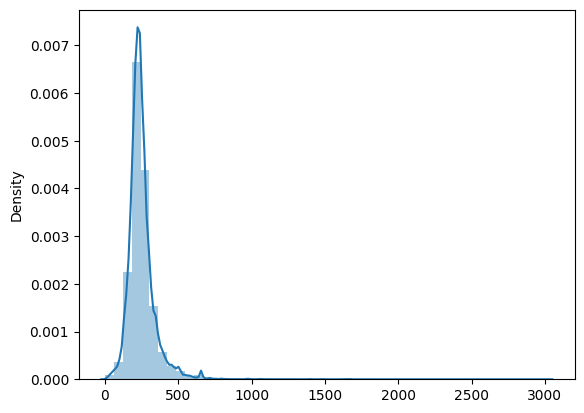

In [133]:
sns.distplot(df.select('length').toPandas().dropna())

In [134]:
df.select('length').select(round(percentile(col('length'), 1), 2).alias('max'),
                          round(percentile(col('length'), 0.999), 2).alias('p_99.9'),
                          round(percentile(col('length'), 0.99), 2).alias('_p99'),
                          round(percentile(col('length'), 0.95), 2).alias('_p95'),
                          round(percentile(col('length'), 0.90), 2).alias('_p90'),
                          round(percentile(col('length'), 0.50), 2).alias('_p50')
                          ).show()

+-------+-------+------+------+------+-----+
|    max| p_99.9|  _p99|  _p95|  _p90| _p50|
+-------+-------+------+------+------+-----+
|3024.67|1087.19|591.67|405.57|344.87|234.5|
+-------+-------+------+------+------+-----+



As expected, the existence of outliers is clear, based on this right-skewed long-tail distribution. Also, the distributions indicate that the percentile 99 had a length of 591, far away from the max 3024 observed in max. 

In [135]:
(df.filter(col('artist')!='no_music_info')
   .groupBy('artist')
   .count()
   .orderBy(col('count').desc())
   .withColumn('total', sum(col('count')).over(Window.partitionBy(lit(1))))
   .withColumn('percent', round(col('count')/col('total'), 4))
).show()

+--------------------+-----+------+-------+
|              artist|count| total|percent|
+--------------------+-----+------+-------+
|       Kings Of Leon| 1841|228108| 0.0081|
|            Coldplay| 1813|228108| 0.0079|
|Florence + The Ma...| 1236|228108| 0.0054|
|       Dwight Yoakam| 1135|228108|  0.005|
|            BjÃÂ¶rk| 1133|228108|  0.005|
|      The Black Keys| 1125|228108| 0.0049|
|                Muse| 1090|228108| 0.0048|
|       Justin Bieber| 1044|228108| 0.0046|
|        Jack Johnson| 1007|228108| 0.0044|
|              Eminem|  953|228108| 0.0042|
|           Radiohead|  884|228108| 0.0039|
|     Alliance Ethnik|  876|228108| 0.0038|
|               Train|  854|228108| 0.0037|
|        Taylor Swift|  840|228108| 0.0037|
|         OneRepublic|  828|228108| 0.0036|
|         The Killers|  822|228108| 0.0036|
|         Linkin Park|  787|228108| 0.0035|
|         Evanescence|  781|228108| 0.0034|
|            Harmonia|  729|228108| 0.0032|
|           Daft Punk|  713|2281

There is no an artist or song that has a higher percent of interactions in the app. However, there is a few artists that has a bbigger interactions than all the others. The top 2 are: Kings Of Leon, Coldplay, with more than 1,5% of songs played togheter. 

In [136]:
(df.groupBy('gender')
   .count()
   .orderBy(col('count').desc())
   .withColumn('total', sum(col('count')).over(Window.partitionBy(lit(1))))
   .withColumn('percent', round(col('count')/col('total'), 4))
).show()

+------+------+------+-------+
|gender| count| total|percent|
+------+------+------+-------+
|     F|154578|278154| 0.5557|
|     M|123576|278154| 0.4443|
+------+------+------+-------+



The public between Females and Males in weel distributed.

In [137]:
(df.groupBy('level')
   .agg(count(col('userId')).alias('count'),
        countDistinct(col('userId')).alias('users')
       )
   .orderBy(col('count').desc())
   .withColumn('total', sum(col('count')).over(Window.partitionBy(lit(1))))
   .withColumn('total_users', sum(col('users')).over(Window.partitionBy(lit(1))))
   .withColumn('percent', round(col('count')/col('total'), 4))
   .withColumn('percent_users', round(col('users')/col('total_users'), 4))
).show()

+-----+------+-----+------+-----------+-------+-------------+
|level| count|users| total|total_users|percent|percent_users|
+-----+------+-----+------+-----------+-------+-------------+
| paid|222433|  165|278154|        360| 0.7997|       0.4583|
| free| 55721|  195|278154|        360| 0.2003|       0.5417|
+-----+------+-----+------+-----------+-------+-------------+



Plus than 75% of interactions are made on paid accounts. However, this doens't means that we has more paid accounts in the app, they are just the public with more interactions.
More the 54% of users, actually, are in free accounts.

<Axes: xlabel='count', ylabel='page'>

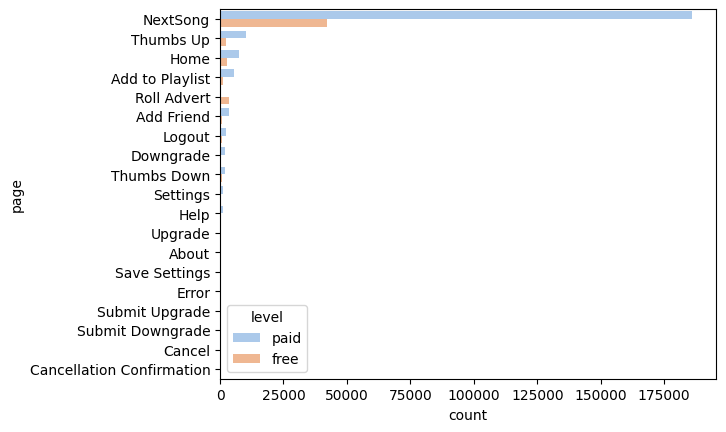

In [138]:
pandas_fd = (df.groupBy('page', 'level').count().orderBy((col('count').desc())).toPandas())
sns.barplot(data=pandas_fd, x='count', y='page', hue='level', palette = 'pastel')

Paid and Free accounts in general has similar interactions, but with a lower frequency in free acounts. Also, there  are a few pages that are more comom percentually in free accounts, for example, Roll Advert.

In [139]:
(df.groupBy('city', 'state')
   .count()
   .orderBy(col('count').desc())
   .withColumn('total', sum(col('count')).over(Window.partitionBy(lit(1))))
   .withColumn('percent', round(col('count')/col('total'), 4))
).show()

+--------------------+------------+-----+------+-------+
|                city|       state|count| total|percent|
+--------------------+------------+-----+------+-------+
|Los Angeles-Long ...|          CA|30131|278154| 0.1083|
|New York-Newark-J...|    NY-NJ-PA|23684|278154| 0.0851|
|Boston-Cambridge-...|       MA-NH|13873|278154| 0.0499|
|Houston-The Woodl...|          TX| 9499|278154| 0.0342|
|Charlotte-Concord...|       NC-SC| 7780|278154|  0.028|
|Dallas-Fort Worth...|          TX| 7605|278154| 0.0273|
|Louisville/Jeffer...|       KY-IN| 6880|278154| 0.0247|
|Philadelphia-Camd...| PA-NJ-DE-MD| 5890|278154| 0.0212|
|Chicago-Napervill...|    IL-IN-WI| 5114|278154| 0.0184|
|           St. Louis|       MO-IL| 4858|278154| 0.0175|
|Phoenix-Mesa-Scot...|          AZ| 4846|278154| 0.0174|
|  Vineland-Bridgeton|          NJ| 4825|278154| 0.0173|
|              Wilson|          NC| 4659|278154| 0.0167|
|Denver-Aurora-Lak...|          CO| 4453|278154|  0.016|
|               Ionia|         

In [140]:
(df.groupBy('userAgent')
   .count()
   .orderBy(col('count').desc())
   .withColumn('total', sum(col('count')).over(Window.partitionBy(lit(1))))
   .withColumn('percent', round(col('count')/col('total'), 4))
).show()

+------------+------+------+-------+
|   userAgent| count| total|percent|
+------------+------+------+-------+
|     Windows|143871|278154| 0.5172|
|         Mac|102749|278154| 0.3694|
|        Mobi| 22573|278154| 0.0812|
|Ubuntu/Linux|  8961|278154| 0.0322|
+------------+------+------+-------+



Finally, plus than 10% of the interactions are in LA, and more than a half of interactions are in Windows systems.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [141]:
(df.groupBy('auth')
   .count()
   .orderBy(col('count').desc())
   .withColumn('total', sum(col('count')).over(Window.partitionBy(lit(1))))
   .withColumn('percent', round(col('count')/col('total'), 4))
).show()

+---------+------+------+-------+
|     auth| count| total|percent|
+---------+------+------+-------+
|Logged In|278102|278154| 0.9998|
|Cancelled|    52|278154| 2.0E-4|
+---------+------+------+-------+



There is 52 records with the flag Cancelled in auth information. Let's take a look in pages info.

In [142]:
(df.groupBy('page', 'auth')
   .count()
   .orderBy(col('count').desc())
   .withColumn('total', sum(col('count')).over(Window.partitionBy(lit(1))))
   .withColumn('percent', round(col('count')/col('total'), 4))
).show()

+--------------------+---------+------+------+-------+
|                page|     auth| count| total|percent|
+--------------------+---------+------+------+-------+
|            NextSong|Logged In|228108|278154| 0.8201|
|           Thumbs Up|Logged In| 12551|278154| 0.0451|
|                Home|Logged In| 10082|278154| 0.0362|
|     Add to Playlist|Logged In|  6526|278154| 0.0235|
|          Add Friend|Logged In|  4277|278154| 0.0154|
|         Roll Advert|Logged In|  3933|278154| 0.0141|
|              Logout|Logged In|  3226|278154| 0.0116|
|         Thumbs Down|Logged In|  2546|278154| 0.0092|
|           Downgrade|Logged In|  2055|278154| 0.0074|
|            Settings|Logged In|  1514|278154| 0.0054|
|                Help|Logged In|  1454|278154| 0.0052|
|             Upgrade|Logged In|   499|278154| 0.0018|
|               About|Logged In|   495|278154| 0.0018|
|       Save Settings|Logged In|   310|278154| 0.0011|
|               Error|Logged In|   252|278154| 9.0E-4|
|      Sub

In [143]:
(df.filter(col('page')=='Cancellation Confirmation')
   .groupBy('level', 'auth')
   .count()
   .orderBy(col('count').desc())
   .withColumn('total', sum(col('count')).over(Window.partitionBy(lit(1))))
   .withColumn('percent', round(col('count')/col('total'), 4))
).show()

+-----+---------+-----+-----+-------+
|level|     auth|count|total|percent|
+-----+---------+-----+-----+-------+
| paid|Cancelled|   31|   52| 0.5962|
| free|Cancelled|   21|   52| 0.4038|
+-----+---------+-----+-----+-------+



All the auth Cancelled records are registered in the same page equal to Cancellation Confirmed. It seems to be a reliable information of Cancelled account. 
Let's create the churn column. We will create a column 'is_churn_event' and a 'is_churn user'. The first one will just give the info of churn in a event level, while the second one will give information in a user level.

In [144]:
df_churn = (df.withColumn('is_churn_event', 
                          when(col('page')=='Cancellation Confirmation', lit(1))
                          .otherwise(lit(0))
             )
              .withColumn('is_user_churn', 
                          max(col('is_churn_event')
                             ).over(Window.partitionBy(col('userId')))
             )
           )

In [145]:
display_pandas_dataframe((df_churn.filter(col('is_churn_event')==1)))

,artist,auth,gender,itemInSession,length,level,method,page,registration,sessionId,song,status,ts,userAgent,userId,city,state,fullName,is_churn_event,is_user_churn
0,no_music_info,Cancelled,M,73,NaN,free,GET,Cancellation Confirmation,2018-07-26 13:15:26,115,no_music_info,200,2018-10-19 17:57:05,Mac,100005,Monroe,LA,Cason Smith,1,1
1,no_music_info,Cancelled,F,45,NaN,free,GET,Cancellation Confirmation,2018-09-26 12:21:23,6,no_music_info,200,2018-10-05 15:24:30,Windows,100006,Flint,MI,Leyla Barnes,1,1
2,no_music_info,Cancelled,F,201,NaN,paid,GET,Cancellation Confirmation,2018-08-06 02:26:59,205,no_music_info,200,2018-11-29 11:45:09,Windows,100007,Little Rock-North Little Rock-Conway,AR,Piper Cook,1,1
3,no_music_info,Cancelled,M,61,NaN,free,GET,Cancellation Confirmation,2018-09-19 17:00:37,145,no_music_info,200,2018-10-27 03:31:44,Windows,100009,San Francisco-Oakland-Hayward,CA,Troy Mathis,1,1
4,no_music_info,Cancelled,M,73,NaN,paid,GET,Cancellation Confirmation,2018-08-27 17:04:03,185,no_music_info,200,2018-11-20 19:04:09,Windows,100014,New York-Newark-Jersey City,NY-NJ-PA,Rodrigo Carey,1,1


In [146]:
display_pandas_dataframe(df_churn.filter(col('sessionId')==174).filter(col('userId')==125), number_limit=15)

,artist,auth,gender,itemInSession,length,level,method,page,registration,sessionId,song,status,ts,userAgent,userId,city,state,fullName,is_churn_event,is_user_churn
0,Christopher O'Riley,Logged In,M,0,337.91955,free,PUT,NextSong,2018-08-01 20:58:59,174,paranoid android,200,2018-10-12 04:05:44,Mac,125,Corpus Christi,TX,Mason Hart,0,1
1,The Notorious B.I.G.,Logged In,M,1,230.03383,free,PUT,NextSong,2018-08-01 20:58:59,174,Hypnotize(Album Version),200,2018-10-12 04:11:21,Mac,125,Corpus Christi,TX,Mason Hart,0,1
2,Betty Boo,Logged In,M,2,203.23220,free,PUT,NextSong,2018-08-01 20:58:59,174,I'm On My Way,200,2018-10-12 04:15:11,Mac,125,Corpus Christi,TX,Mason Hart,0,1
3,Nickelback,Logged In,M,3,210.83383,free,PUT,NextSong,2018-08-01 20:58:59,174,Leader Of Men (Album Version),200,2018-10-12 04:18:34,Mac,125,Corpus Christi,TX,Mason Hart,0,1
4,Ready For The World,Logged In,M,4,391.26159,free,PUT,NextSong,2018-08-01 20:58:59,174,Love You Down,200,2018-10-12 04:22:04,Mac,125,Corpus Christi,TX,Mason Hart,0,1
5,We Are The Fallen,Logged In,M,5,213.60281,free,PUT,NextSong,2018-08-01 20:58:59,174,Don't Leave Me Behind,200,2018-10-12 04:28:35,Mac,125,Corpus Christi,TX,Mason Hart,0,1
6,Robert Johnson,Logged In,M,6,178.41587,free,PUT,NextSong,2018-08-01 20:58:59,174,They're Red Hot,200,2018-10-12 04:32:08,Mac,125,Corpus Christi,TX,Mason Hart,0,1
7,Bonobo,Logged In,M,7,323.81342,free,PUT,NextSong,2018-08-01 20:58:59,174,Kota,200,2018-10-12 04:35:06,Mac,125,Corpus Christi,TX,Mason Hart,0,1
8,no_music_info,Logged In,M,8,NaN,free,GET,Roll Advert,2018-08-01 20:58:59,174,no_music_info,200,2018-10-12 04:35:17,Mac,125,Corpus Christi,TX,Mason Hart,0,1
9,no_music_info,Logged In,M,9,NaN,free,PUT,Cancel,2018-08-01 20:58:59,174,no_music_info,307,2018-10-12 04:35:18,Mac,125,Corpus Christi,TX,Mason Hart,0,1


Let's take a look in Downgrade Event.

In [147]:
(df_churn.filter(col('page').isin('Downgrade'))
         .groupBy('is_user_churn', 'is_churn_event', 'page')
         .agg(countDistinct(col('userId')).alias('users'))
).show()

+-------------+--------------+---------+-----+
|is_user_churn|is_churn_event|     page|users|
+-------------+--------------+---------+-----+
|            0|             0|Downgrade|  119|
|            1|             0|Downgrade|   35|
+-------------+--------------+---------+-----+



In [148]:
(df_churn.groupBy('is_user_churn')
         .agg(countDistinct(col('userId')).alias('users'))
).show()

+-------------+-----+
|is_user_churn|users|
+-------------+-----+
|            1|   52|
|            0|  173|
+-------------+-----+



Besides every user, the tax churn rate is 23%. Between users that visited the Downgrade page, the rate is 35%. Let's create a column to indicates the downgrade too.

In [149]:
df_churn = (df_churn.withColumn('is_downgrade_event', 
                          when(col('page')=='Downgrade', lit(1))
                          .otherwise(lit(0))
             )
              .withColumn('times_user_downgrade', 
                          sum(col('is_downgrade_event')
                             ).over(Window.partitionBy(col('userId')))
             )
           )

In [150]:
display_pandas_dataframe(df_churn)

,artist,auth,gender,itemInSession,length,level,method,page,registration,sessionId,...,ts,userAgent,userId,city,state,fullName,is_churn_event,is_user_churn,is_downgrade_event,times_user_downgrade
0,Evanescence,Logged In,M,0,237.11302,paid,PUT,NextSong,2018-09-26 17:17:35,256,...,2018-10-02 15:04:22,Windows,100,Dallas-Fort Worth-Arlington,TX,Colin Larson,0,0,0,30
1,Sheena Easton,Logged In,M,1,239.62077,paid,PUT,NextSong,2018-09-26 17:17:35,256,...,2018-10-02 15:08:19,Windows,100,Dallas-Fort Worth-Arlington,TX,Colin Larson,0,0,0,30
2,no_music_info,Logged In,M,2,NaN,paid,PUT,Thumbs Down,2018-09-26 17:17:35,256,...,2018-10-02 15:08:20,Windows,100,Dallas-Fort Worth-Arlington,TX,Colin Larson,0,0,0,30
3,Moonbootica (w/IAMX),Logged In,M,3,407.27465,paid,PUT,NextSong,2018-09-26 17:17:35,256,...,2018-10-02 15:12:18,Windows,100,Dallas-Fort Worth-Arlington,TX,Colin Larson,0,0,0,30
4,tobyMac,Logged In,M,4,272.09098,paid,PUT,NextSong,2018-09-26 17:17:35,256,...,2018-10-02 15:19:05,Windows,100,Dallas-Fort Worth-Arlington,TX,Colin Larson,0,0,0,30


Also, a user just downgrade their plan if he had once a paid plan. Let's create a column to indicate if the user had onde the paid account.

In [151]:
df_churn = (df_churn.withColumn('had_paid_account', 
                          when(col('level')=='paid', lit(1))
                          .otherwise(lit(0))
             )
              .withColumn('had_paid_account', 
                          max(col('had_paid_account')
                             ).over(Window.partitionBy(col('userId')))
             )
           )

In [152]:
(df_churn.groupBy('is_user_churn', 'had_paid_account')
         .agg(avg(col('times_user_downgrade')).alias('downgrades_average'),
              countDistinct(col('userId')).alias('users'),
              countDistinct(when(col('times_user_downgrade')>0, col('userId'))).alias('users_w_downgrades')
            )
).show()

+-------------+----------------+------------------+-----+------------------+
|is_user_churn|had_paid_account|downgrades_average|users|users_w_downgrades|
+-------------+----------------+------------------+-----+------------------+
|            1|               0|               0.0|   16|                 0|
|            1|               1|14.405118300338001|   36|                35|
|            0|               0|               0.0|   44|                 0|
|            0|               1|23.224106423004567|  129|               119|
+-------------+----------------+------------------+-----+------------------+



Based on the results above, the downgrades indicates a propensity to cancellate the account. However, there are a lot of customers that downgraded their plans (119 of 129) that do not churn the app. So, to churn rule, we will ust use the Cancellation Information, even that the downgrade column is created and can be use in the further analysis.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [153]:
(df_churn.groupBy('is_user_churn')
         .agg(round(sum(col('length')), 0).alias('time_listen'),
              countDistinct(col('userId')).alias('users'),
              round((sum(col('length'))/countDistinct(col('userId'))), 0).alias('avg_time_listen'),
             )
).show()

+-------------+-----------+-----+---------------+
|is_user_churn|time_listen|users|avg_time_listen|
+-------------+-----------+-----+---------------+
|            1|  9048742.0|   52|       174014.0|
|            0| 4.777688E7|  173|       276167.0|
+-------------+-----------+-----+---------------+



In [154]:
(df_churn.groupBy('is_user_churn')
         .agg(count(col('song')).alias('play_times'),
              countDistinct(col('song')).alias('distinct_songs'),
              round(count(col('song'))/countDistinct(col('userId')), 0).alias('avg_time_listen'),
              round(countDistinct(col('song'))/countDistinct(col('userId')), 0).alias('avg_distinct_songs'),
              round(countDistinct(col('artist'))/countDistinct(col('userId')), 0).alias('avg_distinct_artist'),
             )
).show()

+-------------+----------+--------------+---------------+------------------+-------------------+
|is_user_churn|play_times|distinct_songs|avg_time_listen|avg_distinct_songs|avg_distinct_artist|
+-------------+----------+--------------+---------------+------------------+-------------------+
|            1|     44864|         19217|          863.0|             370.0|              162.0|
|            0|    233290|         53337|         1348.0|             308.0|               96.0|
+-------------+----------+--------------+---------------+------------------+-------------------+



In general, users who churned has a lower average time listening songs. Besides the time listening, the number of songs played are lower too. In terms of distinct songs, actually the users who churn has a higher average of distinct songs played, indicating that they used te app to know musics, but heir freuency by song is not big as the users who not churn.

In [155]:
(df_churn.groupBy('is_user_churn', 'userId')
         .agg(countDistinct(col('page')).alias('pages_interaction'))
         .groupBy('is_user_churn')
         .agg(avg(col('pages_interaction')))
).show()

+-------------+----------------------+
|is_user_churn|avg(pages_interaction)|
+-------------+----------------------+
|            1|    14.884615384615385|
|            0|    13.497109826589595|
+-------------+----------------------+



In [156]:
(df_churn.filter(col('page')!='NextSong')
         .groupBy('is_user_churn', 'userId', 'page')
         .agg(count(col('page')).alias('pages_interaction'))
         .groupBy('is_user_churn', 'page')
         .agg(sum(col('pages_interaction')).alias('pages_interaction'))
         .withColumn('total_interactions', 
                     sum(col('pages_interaction')).over(Window.partitionBy(col('is_user_churn')))
                    )
         .withColumn('percent', col('pages_interaction')/col('total_interactions'))
         .groupBy('page')
         .agg(round(sum(when(col('is_user_churn')==1, col('percent')))*100, 2).alias('churn_user_percent'),
              round(sum(when(col('is_user_churn')==0, col('percent')))*100, 2).alias('not_churn_user_percent')
             )
         .orderBy(col('churn_user_percent').desc())
).show()

+--------------------+------------------+----------------------+
|                page|churn_user_percent|not_churn_user_percent|
+--------------------+------------------+----------------------+
|           Thumbs Up|             21.95|                 25.72|
|                Home|             19.74|                 20.23|
|     Add to Playlist|             12.26|                  13.2|
|         Roll Advert|             11.42|                  7.13|
|          Add Friend|              7.51|                  8.76|
|              Logout|              6.53|                  6.43|
|         Thumbs Down|              5.86|                  4.93|
|           Downgrade|              3.98|                  4.13|
|            Settings|              3.19|                  2.99|
|                Help|              2.82|                  2.92|
|             Upgrade|              1.32|                  0.93|
|       Save Settings|              0.68|                  0.61|
|               About|   

Based on table above, it seems that both users has similars interactions between pages, excepting the page Roll Advert and Thumbs Down, that seems to be more frequent to churn users. On the other hand, users hnow not churn, has more interactions, in share, with Thumbs Up and sharing with Friends.

In [157]:
(df_churn.groupBy('is_user_churn', 'userId')
         .agg(countDistinct(date_format(col('ts'), 'yyyy-MM-dd')).alias('days_interacting'))
         .groupBy('is_user_churn')
         .agg(avg(col('days_interacting')))
).show()

+-------------+---------------------+
|is_user_churn|avg(days_interacting)|
+-------------+---------------------+
|            1|    9.826923076923077|
|            0|   15.104046242774567|
+-------------+---------------------+



In [158]:
(df_churn.groupBy('is_user_churn', 'userId')
         .agg(countDistinct(date_part(lit('WEEK'), col('ts'))).alias('days_interacting'))
         .groupBy('is_user_churn')
         .agg(avg(col('days_interacting')))
).show()

+-------------+---------------------+
|is_user_churn|avg(days_interacting)|
+-------------+---------------------+
|            1|   3.8076923076923075|
|            0|    6.179190751445087|
+-------------+---------------------+



The number of days and week interacting besides who not churn is higher than user who churn. 

In [159]:
(df_churn.groupBy('is_user_churn', 'gender')
         .agg(countDistinct(col('userId')).alias('users'))
         .withColumn('user_per_gender', sum(col('users')).over(Window.partitionBy(col('gender'))))
         .withColumn('percent', col('users')/col('user_per_gender'))
).show()

+-------------+------+-----+---------------+-------------------+
|is_user_churn|gender|users|user_per_gender|            percent|
+-------------+------+-----+---------------+-------------------+
|            1|     F|   20|            104|0.19230769230769232|
|            0|     F|   84|            104| 0.8076923076923077|
|            0|     M|   89|            121| 0.7355371900826446|
|            1|     M|   32|            121| 0.2644628099173554|
+-------------+------+-----+---------------+-------------------+



It seems to not have a relation between churn and gender.

In [160]:
(df_churn.withColumn('month_cohort', date_trunc('month', col('registration')))
 .groupBy('month_cohort')
 .agg((countDistinct(when(col('is_user_churn')==1, col('userId')))/countDistinct(col('userId'))).alias('churn_rate'),
      countDistinct(col('userId')).alias('users')
     )
 .orderBy(col('month_cohort'))
).show()

+-------------------+-------------------+-----+
|       month_cohort|         churn_rate|users|
+-------------------+-------------------+-----+
|2018-03-01 00:00:00|                0.0|    1|
|2018-05-01 00:00:00|                0.5|    2|
|2018-06-01 00:00:00|                0.2|   10|
|2018-07-01 00:00:00|0.14285714285714285|   28|
|2018-08-01 00:00:00|               0.28|   50|
|2018-09-01 00:00:00|0.24031007751937986|  129|
|2018-10-01 00:00:00|                0.0|    1|
|2018-11-01 00:00:00|                0.0|    4|
+-------------------+-------------------+-----+



Even with some months the churn rate being high, this is more related with the fact that the numer of users is small, than related to the fact that the churn is really bad.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [161]:
##firstly let's remove the cancellation record
df_churn = df_churn.filter(col('is_churn_event')!=1)

In [162]:
def get_user_info(df, expression, col_names):
    """
    Description:
        Get aggregated information about the user.
    
    Args:
        df (Dataframe): data to be used in aggregation.
        expression (pyspark function): calculation to be made.
        columns to include in the calculation (string or list): calculation to be made.
        
    Returns:
        df_agg (dataframe): result aggregated by user.
    """
    agregacoes = []
    for col_name in col_names:
    # adding expressions
        agregacoes.append(expression(col(col_name)).alias(f"{expression.__name__}_{col_name}"))

    # Realiza o agrupamento e aplica as agregações
    df_agg = df.groupBy('userId').agg(*agregacoes)
    return df_agg

### 1. Song/Artist Features

Let's create the following features:
1. Unique Artists and Songs
2. Songs
3. No song event
4. Total minutes
4. Date and hours played

In [163]:
df_churn = (df_churn.withColumn('date_event', date_format(col('ts'), 'yyyy-MM-dd'))
                    .withColumn('hour_event', date_part(lit('M'), col('ts')))
           )

In [164]:
only_song_events = (df_churn.filter(col('song')!='no_music_info'))
no_song_events = (df_churn.filter(col('song')=='no_music_info'))

unique_song_artist = get_user_info(only_song_events, countDistinct, ['artist', 'song'])
song = get_user_info(only_song_events, count, ['song'])
no_song = get_user_info(no_song_events, count, ['song']).withColumnRenamed('count_song', 'no_song_events')
unique_song_length = get_user_info(only_song_events, sum, ['length'])
days_listining = get_user_info(only_song_events, countDistinct, ['date_event', 'hour_event'])

In [165]:
##agregating all songs info:
song_features_agg = (unique_song_artist
                     .join(song, on =['userId'], how = 'full')
                     .join(no_song, on =['userId'], how = 'full')
                     .join(unique_song_length, on =['userId'], how = 'full')
                     .join(days_listining, on =['userId'], how = 'full')
                     .withColumn('songs_per_day', col('count_song')/col('countDistinct_date_event'))
                     .withColumn('songs_per_hour', col('count_song')/col('countDistinct_hour_event'))
                     .withColumn('length_per_day', col('sum_length')/col('countDistinct_date_event'))
                     .withColumn('minutes_per_day', col('countDistinct_hour_event')/col('countDistinct_date_event'))
                    )

In [166]:
display_pandas_dataframe(song_features_agg, number_limit = 15)

,userId,countDistinct_artist,countDistinct_song,count_song,no_song_events,sum_length,countDistinct_date_event,countDistinct_hour_event,songs_per_day,songs_per_hour,length_per_day,minutes_per_day
0,10,565,629,673,122,166866.37251,8,60,84.125000,11.216667,20858.296564,7.500000
1,100,1705,2302,2682,532,672877.85659,33,60,81.272727,44.700000,20390.238078,1.818182
2,100001,125,129,133,53,35073.74215,2,55,66.500000,2.418182,17536.871075,27.500000
3,100002,184,193,195,23,49559.91810,5,58,39.000000,3.362069,9911.983620,11.600000
4,100003,50,51,51,26,12306.41932,2,37,25.500000,1.378378,6153.209660,18.500000
5,100004,733,881,942,303,231480.38929,19,60,49.578947,15.700000,12183.178384,3.157895
6,100005,149,153,154,61,37037.12201,4,57,38.500000,2.701754,9259.280503,14.250000
7,100006,26,26,26,17,5854.89105,1,23,26.000000,1.130435,5854.891050,23.000000
8,100007,357,408,423,96,104495.32492,9,60,47.000000,7.050000,11610.591658,6.666667
9,100008,623,723,772,168,191396.79602,8,60,96.500000,12.866667,23924.599502,7.500000


### 2. Interaction in App Features

Let's create the following features:
1. Unique Sessions
2. Unique Events
3. Sessions Duration in Minutes
4. Times that a user downgrade
5. Session Frequency
6. Logs by session
7. Days Between Sessions (using plaform).

In [167]:
df_sessions_info = (df.groupBy('userId', 'sessionId')
                      .agg(min(col('ts')).alias('start_date_session'),
                           max(col('ts')).alias('end_date_sessions')
                          )
                      .withColumn('start_date_session', to_timestamp(col('start_date_session')))
                      .withColumn('end_date_sessions', to_timestamp(col('end_date_sessions')))
                      .withColumn('session_duration', 
                                  col('end_date_sessions')-col('start_date_session'))
                    .withColumn("session_duration_minutes",
                                (col("end_date_sessions").cast("long") - col("start_date_session").cast("long")) / 60
                                )
                   )

df_user_interation_info = (df.groupBy('userId')
                      .agg(min(col('ts')).alias('start_date'),
                           max(col('ts')).alias('end_date')
                          )
                      .withColumn('start_date', to_timestamp(col('start_date')))
                      .withColumn('end_date', to_timestamp(col('end_date')))
                    .withColumn("days_between_sessions",
                                (col("end_date").cast("long") - col("start_date").cast("long")) / (60*60*24)
                                )
                      .drop('start_date', 'end_date')
                   )

In [168]:
unique_sessions = get_user_info(df_churn, countDistinct, ['sessionId'])
unique_logs = get_user_info(df_churn, count, ['userId'])
sessions_duration = get_user_info(df_sessions_info, sum, ['session_duration_minutes'])
user_downgrade = get_user_info(df_churn, avg, ['times_user_downgrade'])

session_features_agg = (unique_sessions
                        .join(unique_logs, on =['userId'], how = 'full')
                        .join(sessions_duration, on =['userId'], how = 'full')
                        .join(df_user_interation_info, on =['userId'], how = 'full')
                        .join(user_downgrade, on =['userId'], how = 'full')
                        .withColumn('session_frequency', col('countDistinct_sessionId')/col('days_between_sessions'))
                        .withColumnRenamed('count_userId', 'count_logs')
                        .withColumn('logs_per_sessions', col('count_logs')/col('countDistinct_sessionId'))
                       )

In [169]:
display_pandas_dataframe(session_features_agg, number_limit = 15)

,userId,countDistinct_sessionId,count_logs,sum_session_duration_minutes,days_between_sessions,avg_times_user_downgrade,session_frequency,logs_per_sessions
0,10,6,795,2758.483333,42.437130,7.0,0.141386,132.500000
1,100,35,3214,11078.166667,58.966285,30.0,0.593560,91.828571
2,100001,4,186,592.633333,1.408576,0.0,2.839747,46.500000
3,100002,4,218,804.733333,55.092951,2.0,0.072605,54.500000
4,100003,2,77,198.233333,2.018067,0.0,0.991047,38.500000
5,100004,21,1245,3905.716667,56.993403,10.0,0.368464,59.285714
6,100005,5,215,600.933333,18.111227,0.0,0.276072,43.000000
7,100006,1,43,93.433333,0.064884,0.0,15.412059,43.000000
8,100007,9,519,1704.700000,58.177153,7.0,0.154700,57.666667
9,100008,6,940,3169.516667,48.999479,10.0,0.122450,156.666667


### 3. User Features

Let's create the following features:

1. Gende
2. User Agent
3. Had paid account

In [170]:
df_churn = (df_churn
            .withColumn('gender', when(col('gender')=='F', lit(1)).otherwise(0))
            .withColumn('userAgent_Mac', when(col('userAgent')=='Mac', lit(1)).otherwise(0))
            .withColumn('userAgent_Ubuntu_Linux', when(col('userAgent')=='Ubuntu/Linux', lit(1)).otherwise(0))
            .withColumn('userAgent_Mobi', when(col('userAgent')=='Mobi', lit(1)).otherwise(0))
            .withColumn('userAgent_Windows', when(col('userAgent')=='Windows', lit(1)).otherwise(0))
           )


user_features_agg = get_user_info(df_churn, max, ['gender', 'userAgent_Mac', 'userAgent_Ubuntu_Linux', 
                                                'userAgent_Mobi', 'userAgent_Windows', 'had_paid_account'
                                               ]
                                 )

### 4. Pages Features

Let's create the following features:

1. Count in each page event

In [171]:
pivot_pages = (df_churn.groupBy("userId")
               .pivot("page")
               .count()
               .fillna(0)
              )

new_column_names = [col_name.replace(" ", "_") for col_name in pivot_pages.columns]
pivot_pages = pivot_pages.toDF(*new_column_names)

pages_features_agg = pivot_pages

### 5. Getting all features Toghether

In [172]:
all_features_agg = (song_features_agg
                    .join(session_features_agg, on = ['userId'], how = 'full')
                    .join(user_features_agg, on = ['userId'], how = 'full')
                    .join(pages_features_agg, on = ['userId'], how = 'full')
                   )

In [173]:
display_pandas_dataframe(all_features_agg, 20)

25/08/16 04:34:09 WARN DAGScheduler: Broadcasting large task binary with size 1005.7 KiB


,userId,countDistinct_artist,countDistinct_song,count_song,no_song_events,sum_length,countDistinct_date_event,countDistinct_hour_event,songs_per_day,songs_per_hour,...,Logout,NextSong,Roll_Advert,Save_Settings,Settings,Submit_Downgrade,Submit_Upgrade,Thumbs_Down,Thumbs_Up,Upgrade
0,10,565,629,673,122,166866.37251,8,60,84.125000,11.216667,...,11,673,1,1,7,0,0,4,37,0
1,100,1705,2302,2682,532,672877.85659,33,60,81.272727,44.700000,...,35,2682,25,5,11,1,1,27,148,1
2,100001,125,129,133,53,35073.74215,2,55,66.500000,2.418182,...,7,133,14,0,1,0,0,2,8,2
3,100002,184,193,195,23,49559.91810,5,58,39.000000,3.362069,...,1,195,3,0,0,0,0,0,5,0
4,100003,50,51,51,26,12306.41932,2,37,25.500000,1.378378,...,3,51,9,0,0,0,0,0,3,0
5,100004,733,881,942,303,231480.38929,19,60,49.578947,15.700000,...,19,942,86,2,11,2,3,11,35,8
6,100005,149,153,154,61,37037.12201,4,57,38.500000,2.701754,...,3,154,18,0,2,0,0,3,7,4
7,100006,26,26,26,17,5854.89105,1,23,26.000000,1.130435,...,1,26,3,0,1,0,0,2,2,0
8,100007,357,408,423,96,104495.32492,9,60,47.000000,7.050000,...,5,423,5,1,3,0,0,6,19,0
9,100008,623,723,772,168,191396.79602,8,60,96.500000,12.866667,...,7,772,20,0,3,1,0,6,37,4


There are 43 columns fully with information to be used in a churn prediction. One of them is the UserId, to be used to identifiy each customer. Also, there are other columns to label the churn. All the other columns will be analysed and selected to perform the prediction model.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [174]:
##defining the label 
y_label = df_churn.select('userId', 'is_user_churn').dropDuplicates()

In [175]:
print(f'We will use {len(all_features_agg.columns)-1} features to model a churn prediction.')

We will use 42 features to model a churn prediction.


In [176]:
y_label.groupBy('is_user_churn').count().show()

+-------------+-----+
|is_user_churn|count|
+-------------+-----+
|            1|   52|
|            0|  173|
+-------------+-----+



### 5.1 Correlation Analysis

All these features will be correlated to find possible features with a high correlation with each other. If two features have a strongly correlation, they will be analysed and possible removed from the dataset, in order to reduce the amount of data

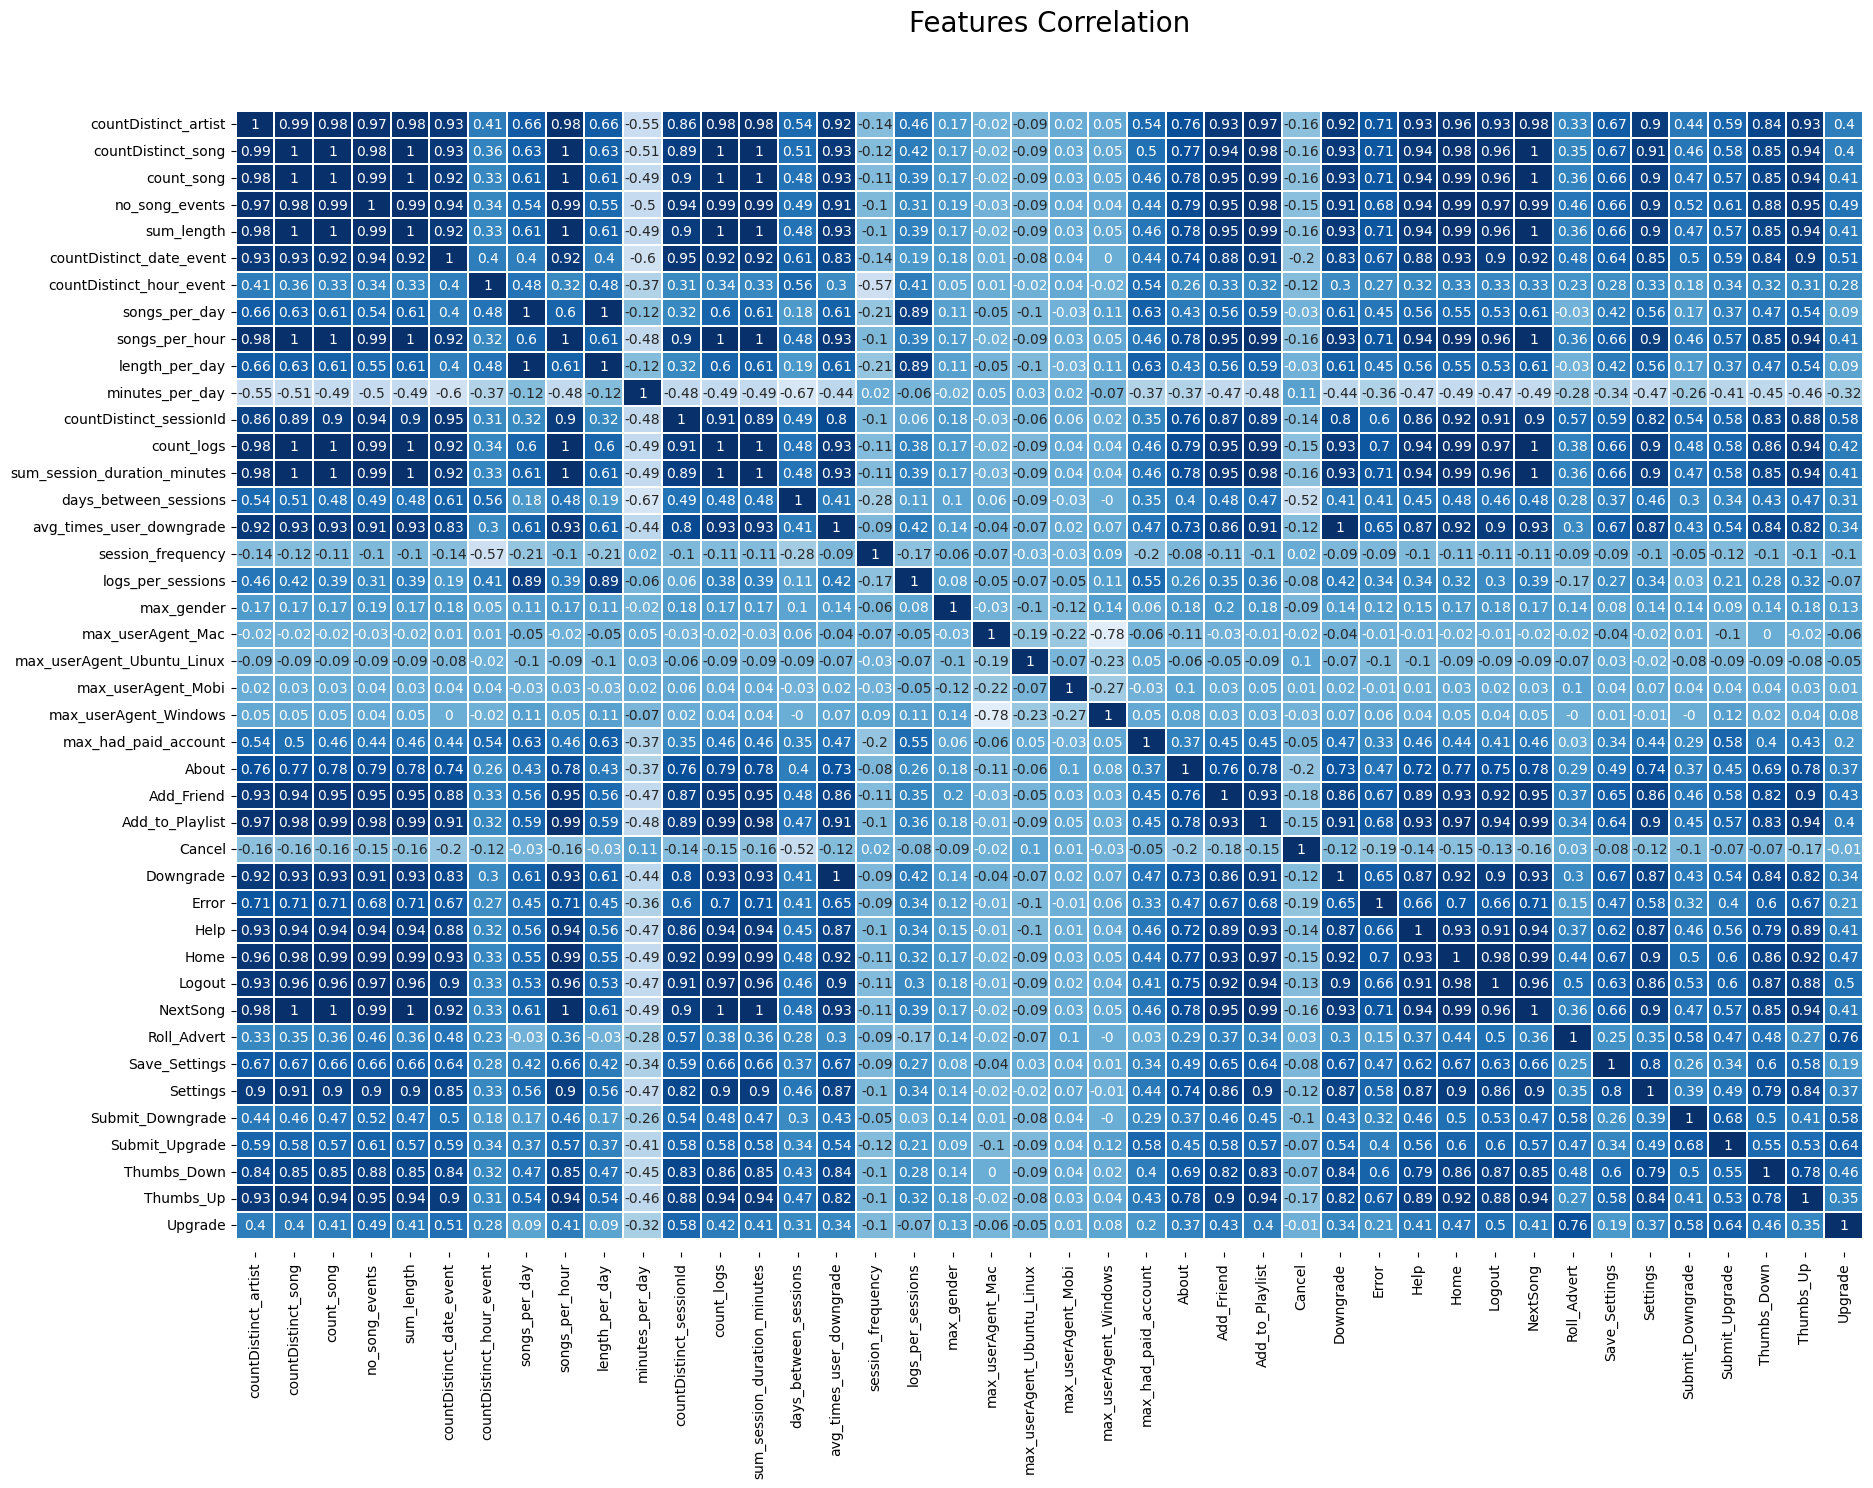

In [177]:
corr_df = all_features_agg.toPandas()

# Plot correlation heatmap
plt.figure(figsize = [21, 15])
plt.title('Features Correlation', y=1.05, size=20)
plt.yticks(rotation = 45)

ax = sns.heatmap(corr_df.iloc[:, 1:].corr().round(2), 
                annot=True, 
                square=False,
                cbar=False, 
                linewidth=0.2,
                cmap = 'Blues',
                vmin = -1, 
                vmax = 1)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

There are a lot of fetures that are strongly correlated and these features will be removed from the modeling step. Besides this, we need o redue the number of features in model.


1. Next Songs (highly correlated to all songs features).
2. Count Logs (highly correlated to all songs features and pages features).
3. Sum Sessions Duration Minutes (highly correlated to all songs features and pages features).
4. Downgrade (highly correlated to how many times a user downgrade)
5. Sum Length, Songs Per Hour and Count Songs (highly correlated to distinct songs played)
6. Cancel event, after analyse tat this feature create an overfit model

In [178]:
new_all_features_agg = all_features_agg.drop('NextSong', 
                                             'count_logs',
                                             'sum_sessions_duration_minutes', 
                                             'Cancel', 
                                             'Downgrade',
                                             'songs_per_hour', 
                                             'sum_length', 
                                             'count_song'
                                            ).fillna(0)

25/08/16 04:34:55 WARN DAGScheduler: Broadcasting large task binary with size 1005.7 KiB


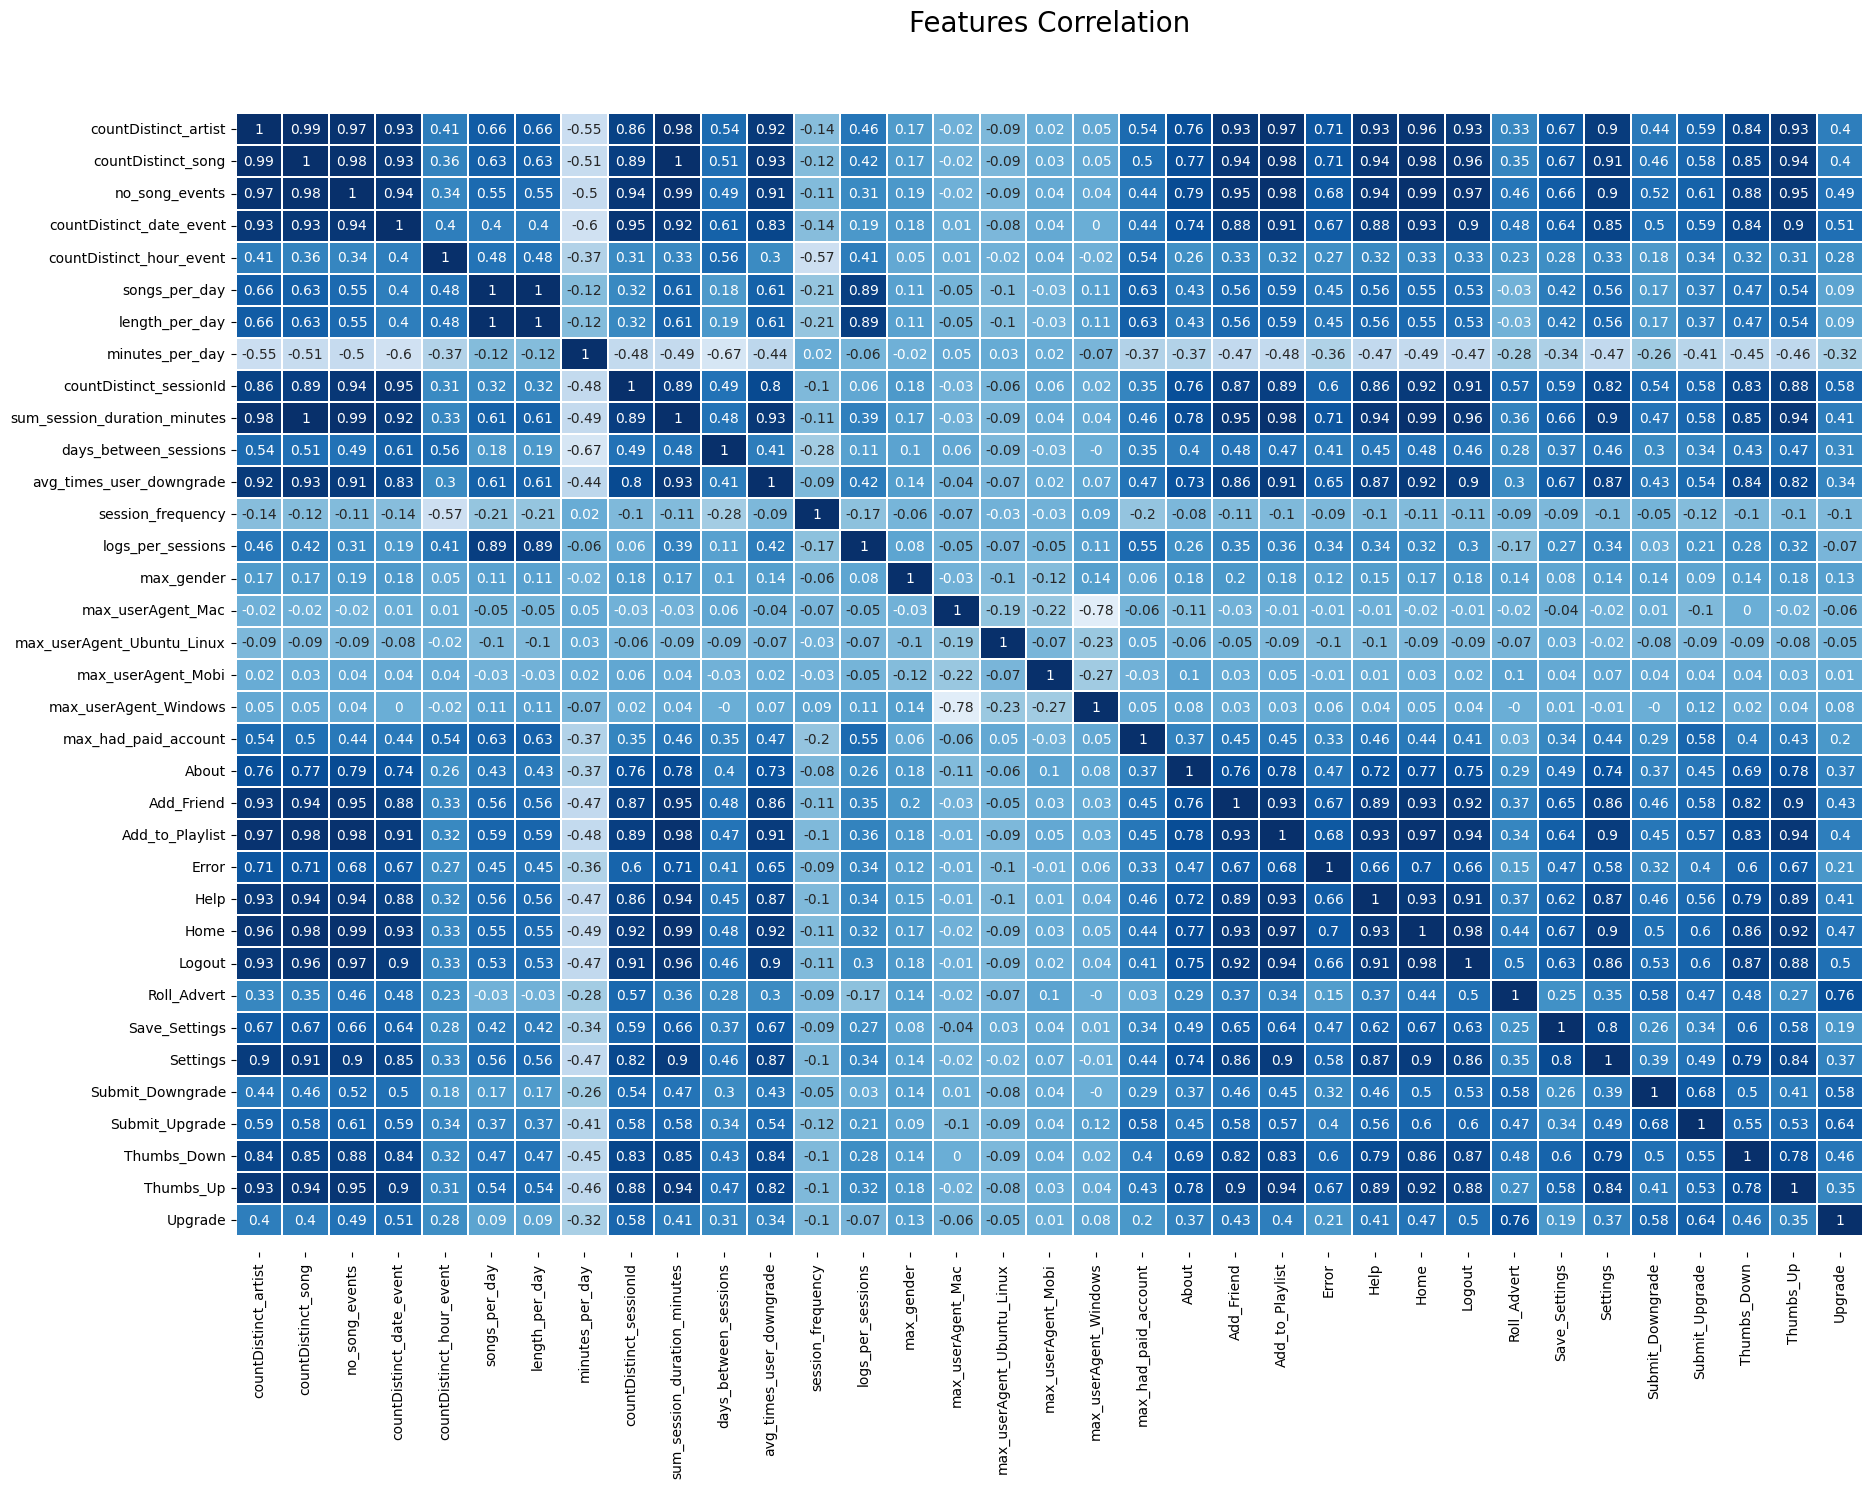

In [179]:
corr_df = new_all_features_agg.toPandas()

# Plot correlation heatmap
plt.figure(figsize = [21, 15])
plt.title('Features Correlation', y=1.05, size=20)
plt.yticks(rotation = 45)

ax = sns.heatmap(corr_df.iloc[:, 1:].corr().round(2), 
                annot=True, 
                square=False,
                cbar=False, 
                linewidth=0.2,
                cmap = 'Blues',
                vmin = -1, 
                vmax = 1)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Even dropping some columns, there are a lot of features in this model. We could reduze more, however, there are features that is related with a small interaction with the app and the hipothesis is that these features will be important to predict a churn. Let's model and use Feature Importances to analyze batter what we can remove.

### 5.3. Applying Models

In [180]:
##creating dataset 
data = (new_all_features_agg.join(y_label, on = ['userId'], how = 'left')
        .withColumnRenamed('is_user_churn', 'label')
        .drop('userId')
       )

In [181]:
data.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [182]:
data.columns

['countDistinct_artist',
 'countDistinct_song',
 'no_song_events',
 'countDistinct_date_event',
 'countDistinct_hour_event',
 'songs_per_day',
 'length_per_day',
 'minutes_per_day',
 'countDistinct_sessionId',
 'sum_session_duration_minutes',
 'days_between_sessions',
 'avg_times_user_downgrade',
 'session_frequency',
 'logs_per_sessions',
 'max_gender',
 'max_userAgent_Mac',
 'max_userAgent_Ubuntu_Linux',
 'max_userAgent_Mobi',
 'max_userAgent_Windows',
 'max_had_paid_account',
 'About',
 'Add_Friend',
 'Add_to_Playlist',
 'Error',
 'Help',
 'Home',
 'Logout',
 'Roll_Advert',
 'Save_Settings',
 'Settings',
 'Submit_Downgrade',
 'Submit_Upgrade',
 'Thumbs_Down',
 'Thumbs_Up',
 'Upgrade',
 'label']

In [183]:
def split_data(data, seed=0):
    """
    Description:
        Data will be divided into training and testing subsets. I use a fixed split ratio of 70:30.
    
    Args:
        df (DataFrame): the model dataframe with features.
        seed (int): a seed value of the random number generator.
        
    Returns:
        train (DataFrame): the training subset.
        test (DataFrame): the testing subset.
    """
    
    train, test = data.randomSplit([0.7, 0.3], seed=seed);
    return train, test

In [184]:
def calc_metrics(model, subset):
    """
    Description:
        The model's metrics computed.
    
    Args:
        model: the fitted model.
        subset: the testing/validation subset.
        
    Returns:
        metrics calculated: the fitted model's metrics.
    """
    
    evaluator_multi = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')
    evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')

    predict = model.transform(subset).select('label', 'prediction')

    acc = evaluator_multi.evaluate(predict, {evaluator_multi.metricName: 'accuracy'})
    f1 = evaluator_multi.evaluate(predict, {evaluator_multi.metricName: 'f1'})
    weightedPrecision = evaluator_multi.evaluate(predict, {evaluator_multi.metricName: 'weightedPrecision'})
    weightedRecall = evaluator_multi.evaluate(predict, {evaluator_multi.metricName: 'weightedRecall'})
    auc = evaluator.evaluate(predict)
    
    metrics_calculated = pd.DataFrame(index=['F1', 'accuracy', 'weighted precision', 'weighted recall', 'AUC'],
                                     data={'metrics value': [f1, acc, weightedPrecision, weightedRecall, auc]})
    
    return metrics_calculated

In [185]:
def stating_process(data, seed):
    """
    Description:
        Starting ML process.
    
    Args:
        data (DataFrame): the model data.
        seed (int): a seed value of the random number generator.
    
    Returns:
        train (DataFrame): the training subset.
        test (DataFrame): the testing subset.
        df_features (DataFrame): df with features
        start (Datetime): start time process
    """
    print('Starting Pipeline.')
    start = time.time()
    df_features = data.drop('userId')

    # Split data into train and test
    train, test = split_data(df_features, seed)
    print('Train and Test data created.')
    
    return train, test, df_features, start

def creating_pipeline(df_features, classifier):
    """
    Description:
        Creating ML Pipeline.
    
    Args:
        df_features (DataFrame): the model data.
        classifier (): a machine learning classifier.
    
    Returns:
        scaler: the StandartScaler declared with features  to be used in pipeline.
        assembler: the VectorAssembler to be used in pipeline.
        pipeline: the pipelina with stages defined.
    """
    
    scaler = StandardScaler(inputCol='num_features', outputCol='features')
    assembler = VectorAssembler(inputCols=(df_features.drop('label')).columns, outputCol='num_features')
    pipeline = Pipeline(stages=[assembler, scaler, classifier])
    print('Create pipeline done.')
    
    return scaler, assembler, pipeline

In [186]:
def fit_model(data, classifier, seed=0):
    """
    Description:
        Fits the machine learning model and computes metrics.
    
    Args:
        data (DataFrame): the model data with features.
        classifier (Lib): a machine learning classifier. 
        seed (int): a seed value of the random number generator.
        
    Returns:
        model: the fitted model.
        metrics: the model's metrics.
    """
    
    train, test, df_features, start = stating_process(data, seed)
    print('Train and Test data created.')

    scaler, assembler, pipeline = creating_pipeline(df_features, classifier)

    # Training model
    model = pipeline.fit(train)
    print('Training done.')

    # Getting metrics
    metrics = calc_metrics(model, test)
    print('Metrics prepared.')

    duration = time.time() - start
    
    print(f'Model fitted. The proccess took {int(duration)} s.')
    
    return model, metrics

In [187]:
# Plot feature importances
def plot_feature_importance(data, model):
    """
    Description:
        Graph showing the importance of each feature in ML model.
    
    Args:
        data (DataFrame): the model data with features.
        model: the fitted model.
        height (int): the plot's figure height.
        title (str): the plot's title.
    
    Returns:
        None
    """
    
    features = data.drop('label')
    print(f'Getting feature importance from model: {model.stages[-1].uid}')
    
    if 'LogisticRegression' in model.stages[-1].uid:
        print('Is a Logisti model')
        feature_coeff = model.stages[-1].coefficients
        title = 'Model Coefficients'
    
    else:
        feature_coeff = model.stages[-1].featureImportances
        title = 'Feature Importance'
    
    metrics = pd.DataFrame([(str(col), coef) for col, coef in zip(features, feature_coeff)], columns=['Feature', 'FeatureImportances'])
    metrics['Feature'] = metrics['Feature'].str.extract(r'<(.*?)>')
    
    indices = metrics['Feature']
    values = metrics['FeatureImportances']

    # Crie um DataFrame a partir dos índices e valores
    feature_importances = pd.DataFrame({'Index': indices, 'Value': values})

    values = feature_importances.sort_values(by='Value', ascending=False)['Value']
    labels = feature_importances.sort_values(by='Value', ascending=False)['Index']

    plt.figure(figsize = [8, 10])
    plt.barh(np.arange(len(values)), values, height=0.6)
    ax = plt.gca()
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('FeatureImportances')
    ax.set_ylabel('Features')
    ax.set_title(title)
    plt.grid(True, axis='x', linewidth= 1)

    plt.show()

In [188]:
def fit_model_cv(data, classifier, paramGrid, numFolds=2, seed=0):
    """
    Description:
        Fits the cross-validation model for tuning hyperparameters.
    
    Args:
        data (DataFrame): the model data.
        classifier (lib): a machine learning classifier. 
        paramGrid: a ParamGridBuilder object with hyperparameters.
        numFolds: the number of folds in the cross-validation tuning.
    
    Returns:
        model_cv: the cross-validation model.
        scores_cv: the cross-validation scores.
    """
    
    train, test, df_features, start = stating_process(data, seed)
    
    
    scaler, assembler, pipeline = creating_pipeline(df_features, classifier)
    
    #Creating cv
    crossValidator = CrossValidator(estimator = pipeline,
                              estimatorParamMaps = paramGrid,
                              evaluator = MulticlassClassificationEvaluator(),
                              numFolds = numFolds)

    #Fit cv
    model_cv = crossValidator.fit(train)
    
    duration = time.time() - start  
    print(f'Cross validation done ({int(duration)} s).')

    #Calculating CV scores
    scores = model_cv.avgMetrics
    params_ = pd.DataFrame(
        [{x.name: y for x, y in e.items()} for e in model_cv.getEstimatorParamMaps()]
    )
    params_['score'] = scores
    
    scores_cv = params_.sort_values(by='score', ascending=False)
    
    return model_cv, scores_cv

Spark support some algorithms for Classification, based on this [documention](https://spark.apache.org/docs/latest/ml-classification-regression.html#classification).

In this project, four models woulb be tested:

- Gradient-boosted tree classifier
- Logistic regression
- Decision tree classifier
- Random forest classifier

#### Gradient Boost Tree Classifier

In [189]:
# Fit model
classifier = GBTClassifier()
model_gbt, metrics_gradient_boost = fit_model(data, classifier)

Starting Pipeline.
Train and Test data created.
Train and Test data created.
Create pipeline done.


25/08/16 04:36:04 WARN DAGScheduler: Broadcasting large task binary with size 1005.7 KiB


Training done.


25/08/16 04:37:10 WARN DAGScheduler: Broadcasting large task binary with size 1005.7 KiB


Metrics prepared.
Model fitted. The proccess took 163 s.


In [190]:
metrics_gradient_boost

,metrics value
F1,0.794391
accuracy,0.777778
weighted precision,0.849003
weighted recall,0.777778
AUC,0.806122


The first Model trained demonstrates a high accuracy and F1. 
The model achieved good performance with an F1-Score of 79.4%, especially considering that churned users represent only 23% of the dataset. The high precision of 84.9% indicates that when the model predicts churn, it is correct in most cases, minimizing false alarms. The AUC of 80.6% demonstrates good predictive capacity and ability to distinguish between users who will churn versus those who will remain active subscribers.

Getting feature importance from model: GBTClassifier_775771648459


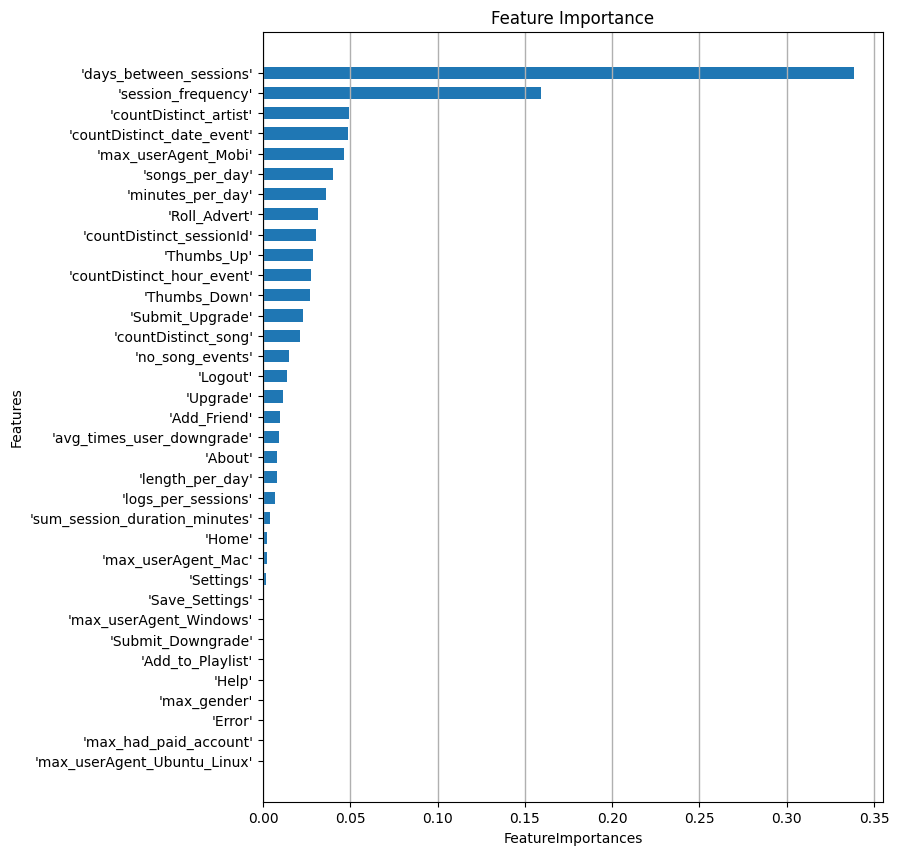

In [191]:
plot_feature_importance(data, model_gbt)

The days between sessions and sessions frequency are very strong to the Gradiant Boos model. 
Actually, the session frequency uses the days between sessions feature to be calculated. This creates multicolinearidade, where two highly correlated features provide essentially the same information, potentially leading to unstable coefficient estimates and making the model harder to interpret.

Also, having features that are mathematically dependent on each other can cause the Gradient Boosting model to overweight temporal session patterns, potentially reducing its ability to generalize to new, unseen data. 

To improve these model, it must be useful to consider remove one of these datas.

I will check other parameters to see if the model can perform better.

In [192]:
# Create classifier
classifier = GBTClassifier()

# Define params grid
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(classifier.maxIter, [5, 10, 20]) \
    .addGrid(classifier.maxDepth,[2, 3, 5]) \
    .addGrid(classifier.maxBins, [32, 20]) \
    .build()

# Fit cross-validation model
model_gbt_cv, scores_gbt_cv = fit_model_cv(data, classifier, paramGrid_gbt)

Starting Pipeline.
Train and Test data created.
Create pipeline done.


25/08/16 04:38:43 WARN DAGScheduler: Broadcasting large task binary with size 1001.3 KiB
25/08/16 04:38:58 WARN DAGScheduler: Broadcasting large task binary with size 1001.3 KiB
25/08/16 04:39:13 WARN DAGScheduler: Broadcasting large task binary with size 1001.3 KiB
25/08/16 04:39:27 WARN DAGScheduler: Broadcasting large task binary with size 1001.3 KiB
25/08/16 04:39:48 WARN CacheManager: Asked to cache already cached data.
25/08/16 04:39:48 WARN CacheManager: Asked to cache already cached data.
25/08/16 04:39:56 WARN DAGScheduler: Broadcasting large task binary with size 1002.9 KiB
25/08/16 04:40:10 WARN DAGScheduler: Broadcasting large task binary with size 1002.9 KiB
25/08/16 04:40:25 WARN DAGScheduler: Broadcasting large task binary with size 1002.9 KiB
25/08/16 04:40:40 WARN DAGScheduler: Broadcasting large task binary with size 1002.9 KiB


Cross validation done (251 s).


In [193]:
scores_gbt_cv

,maxIter,maxDepth,maxBins,score
12,20,2,32,0.868321
6,10,2,32,0.859160
0,5,2,32,0.848696
7,10,2,20,0.846349
1,5,2,20,0.846349
13,20,2,20,0.846349
2,5,3,32,0.838486
8,10,3,32,0.838486
14,20,3,32,0.828020
16,20,5,32,0.802244


The better hyperparameter found to perform de GBT is 20 max Inter, 2 maxDepth and 32 maxBins.

#### Logistic Regression

In [194]:
# Fit model
classifier = LogisticRegression(featuresCol="features", labelCol="label")
model_reg_log, metrics_reg_log = fit_model(data, classifier)

Starting Pipeline.
Train and Test data created.
Train and Test data created.
Create pipeline done.


Training done.


Metrics prepared.
Model fitted. The proccess took 199 s.


In [195]:
metrics_reg_log

,metrics value
F1,0.841270
accuracy,0.841270
weighted precision,0.841270
weighted recall,0.841270
AUC,0.770408


Comparing to the Gradient Boost, the Logistic Regression fitted well. With a higher F1, Acuracy and Recall, the model seems to perform better. This model is just loosing in AUC and weighted precision. The choice between models depends on which metrics are most critical for the business objectives.
he lower weighted precision in Logistic Regression means more false positives - incorrectly identifying non-churning users as at-risk. While this might trigger unnecessary retention campaigns, the higher recall ensures fewer actual churning users are missed, which is typically more costly for the business.
Considering that Sparkify must prefer to invest in a user to prevent its churn, even loosing his money to a false positive, the Logistic Regression should be choose. However, if the budget is a problem if the precision is more important - just spend in actions with how will churn - the GBT should be the right choice. 
In this projet, we will consider the first path, and give more importance to Recall.

Getting feature importance from model: LogisticRegression_cbf6a9b1ee92
Is a Logisti model


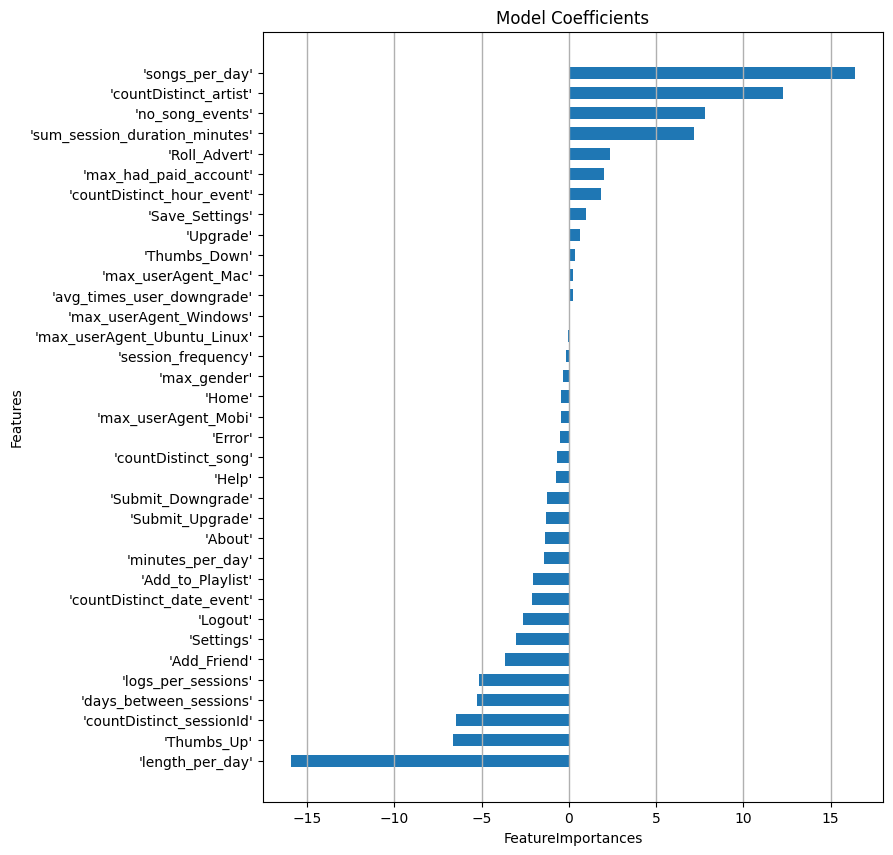

In [196]:
plot_feature_importance(data, model_reg_log)

For Logistic Regression, the absolute magnitude of the coefficients in coef can be interpreted as an indicator of feature importance. Larger absolute coefficient values suggest a stronger influence of that feature on the model's predictions.

It seems that the most important features are the interactions ones,  as the unique artists listened and songs per day. Also, there are negative features, as minutes per day. 

### Decision tree classifier

In [197]:
# Fit model
classifier = DecisionTreeClassifier(labelCol="label", featuresCol="features")
model_dec_tree, metrics_dec_tree = fit_model(data, classifier)

Starting Pipeline.
Train and Test data created.
Train and Test data created.
Create pipeline done.


Training done.


Metrics prepared.
Model fitted. The proccess took 172 s.


In [198]:
metrics_dec_tree

,metrics value
F1,0.809706
accuracy,0.793651
weighted precision,0.872865
weighted recall,0.793651
AUC,0.841837


Comparing with Logistic Regression, the decision tree do not perfomed a better fit considering the Recall and F1. 
Also, the accuraccy wasn't better either. Just the AUC metric is better using this classifier. 

Getting feature importance from model: DecisionTreeClassifier_b11c71a926a0


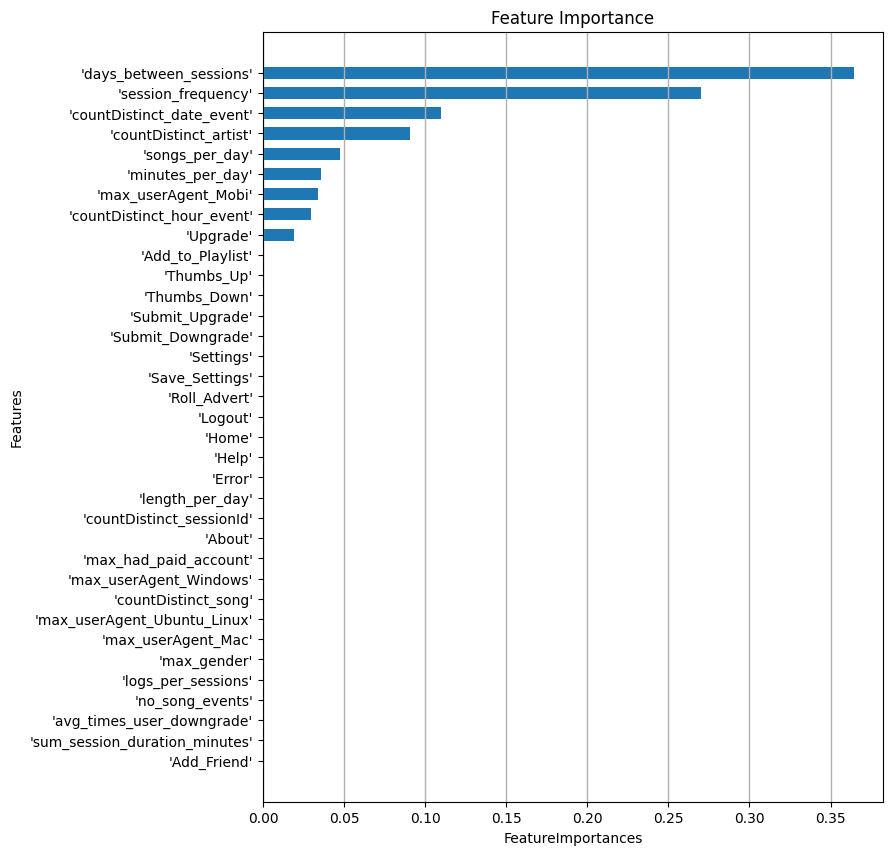

In [199]:
plot_feature_importance(data, model_dec_tree)

As in Gradient Boost Model, the days between sessions and session frequency are highly important in this model.

In [200]:
# Create classifier
classifier = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# Define params grid
paramGrid_dec_tree = ParamGridBuilder() \
    .addGrid(classifier.maxDepth,[5, 10]) \
    .addGrid(classifier.maxBins, [32, 20]) \
    .build()

# Fit cross-validation model
model_dec_tree, scores_dec_tree = fit_model_cv(data, classifier, paramGrid_dec_tree)

Starting Pipeline.
Train and Test data created.
Create pipeline done.


Cross validation done (171 s).


In [201]:
scores_dec_tree

,maxDepth,maxBins,score
0,5,32,0.802244
2,10,32,0.802244
3,10,20,0.770543
1,5,20,0.763079


### Random forest classifier

In [202]:
# Fit model
classifier = RandomForestClassifier()
model_rand_for, metrics_rand_for = fit_model(data, classifier)

Starting Pipeline.
Train and Test data created.
Train and Test data created.
Create pipeline done.


Training done.


Metrics prepared.
Model fitted. The proccess took 220 s.


In [203]:
model_rand_for.stages[-1:]

[RandomForestClassificationModel: uid=RandomForestClassifier_b99e28faa64e, numTrees=20, numClasses=2, numFeatures=35]

In [204]:
metrics_rand_for

,metrics value
F1,0.824204
accuracy,0.841270
weighted precision,0.831313
weighted recall,0.841270
AUC,0.693878


At Random Forecast Model, the Recall is very similar from Logistic Regression Model (82,5%). 
Also, the accuraccy is very similar too. However, the AUC, Precision and F1 are better in RandomForest, so, this should be the model choosed, since the recall are so good as the previous one, and the false positives will be lower. 

Getting feature importance from model: RandomForestClassifier_b99e28faa64e


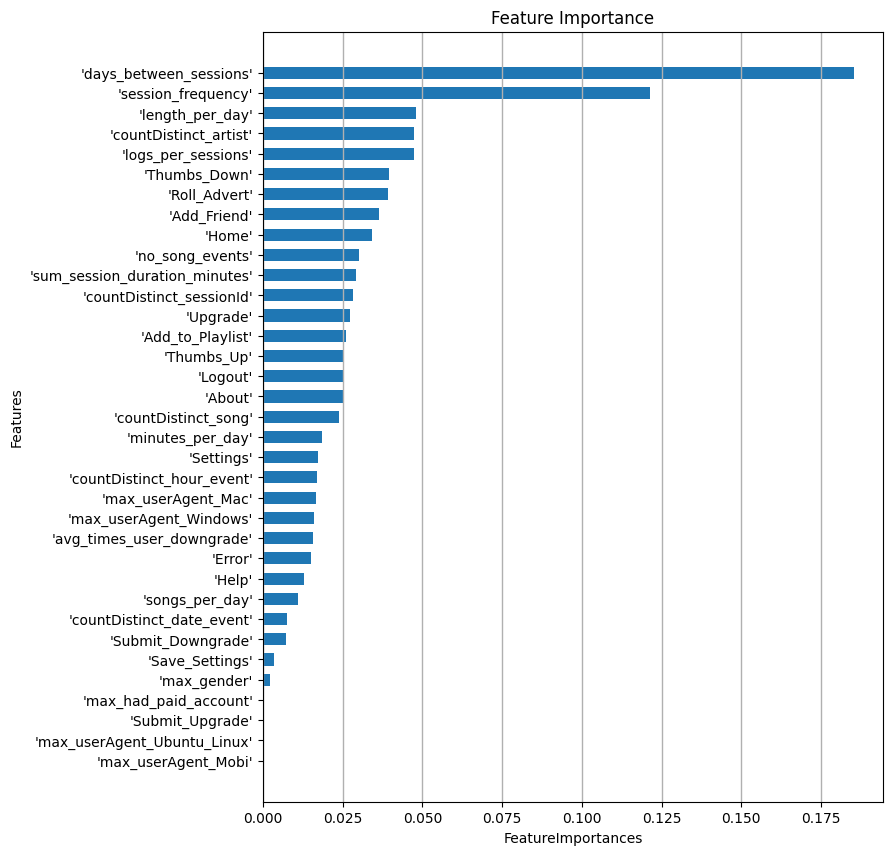

In [205]:
plot_feature_importance(data, model_rand_for)

At Random Forecast Model, the most important features are days between sessions and sessions frequency. Also, other interactions as Thumbs Down or Add to Playslit are also important too. 

Lets run the Grid Search and Cross Validator.

In [206]:
# Create classifier
classifier = RandomForestClassifier()

# Define params grid
paramGrid_rand_for = ParamGridBuilder()\
    .addGrid(classifier.maxBins, [20, 30, 40, 50, 60])\
    .addGrid(classifier.maxDepth, [5, 10, 15, 20, 25])\
    .addGrid(classifier.numTrees, [20, 30, 50])\
    .build()

# Fit cross-validation model
model_rand_for, scores_rand_for = fit_model_cv(data, classifier, paramGrid_rand_for)

Starting Pipeline.
Train and Test data created.
Create pipeline done.


Cross validation done (493 s).


In [207]:
model_rand_for

CrossValidatorModel_52e240bf864e

In [208]:
scores_rand_for

,maxBins,maxDepth,numTrees,score
1,20,5,30,0.796683
0,20,5,20,0.794227
35,40,10,50,0.794227
41,40,20,50,0.794227
44,40,25,50,0.794227
...,...,...,...,...
43,40,25,30,0.729851
34,40,10,30,0.729851
40,40,20,30,0.729851
37,40,15,30,0.729851


The results demonstrated that Logistic Regression and Random Forest were the most effective models, outperforming other algorithms in critical metrics such as F1-Score, Accuracy, and Recall. Between these two models, they have very similar performance, but the Logistic Regression represents a higher precision, F1 e AUC.

The most important features identified were session frequency and days between sessions, validating that temporal engagement patterns are the primary indicators of churn risk. Based on these temporal insights, several strategic interventions could be implemented: offering loyalty bonuses or benefits to long-term platform users, sending targeted notifications with compelling calls-to-action to re-engage users showing declining activity patterns, or implementing automated campaigns triggered by specific engagement thresholds to bring users back to the platform before they reach the point of cancellation.

The final model offers a practical and interpretable solution for production implementation, enabling Sparkify to proactively identify at-risk users and deploy targeted retention strategies. This predictive capability transforms reactive customer service into a proactive retention system, potentially improving customer lifetime value and reducing acquisition costs by focusing resources on preserving existing user relationships rather than constantly replacing churned subscribers.

In [227]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Sparkify.ipynb', '--to', 'html'])

[NbConvertApp] Converting notebook Sparkify.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 8 image(s).
[NbConvertApp] Writing 3262649 bytes to Sparkify.html


0